## Salifort Motors Capstone: Providing data-driven suggestions for HR

#### Scenario

Salifort Motors is a fictional French-based alternative energy vehicle manufacturer. Its global workforce of over 100,000 employees research, design, construct, validate, and distribute electric, solar, algae, and hydrogen-based vehicles. Salifort’s end-to-end vertical integration model has made it a global leader at the intersection of alternative energy and automobiles.

Right now, Salifort Motors has employee issue in increasing employees' retention. They need a model that predicts whether an employee will leave the company. By building a model, the HR hopefully discovers the reason behind their departure, so that they could understand the problem and develop the solution.

### Step 1: Import

In [1]:
# import packages
# for data manipulation
import numpy as np
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# for data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# for metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# for saving models
import pickle

In [2]:
# load the dataset
df0 = pd.read_csv(r"E:\Portfolio Data\HR_Sailfort_dataset.csv")

In [3]:
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Step 2: Data Exploration (Initial EDA and Data Cleaning)

#### Gather basic information about the data

In [4]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


#### Gather descriptive statistics about the data

In [5]:
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


#### Rename columns

In [6]:
# display all column names
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [7]:
# rename the columns so that it follows standardized column names
df0 = df0.rename(columns={'average_montly_hours':'average_monthly_hours',
                          'Work_accident': 'work_accident',
                          'Department':'department',
                         'time_spend_company': 'tenure'})

In [8]:
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

#### Check missing values

In [9]:
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

#### Check duplicates

In [10]:
df0.duplicated().sum()

np.int64(3008)

In [11]:
df1 = df0.drop_duplicates(keep='first')
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


#### Check outliers

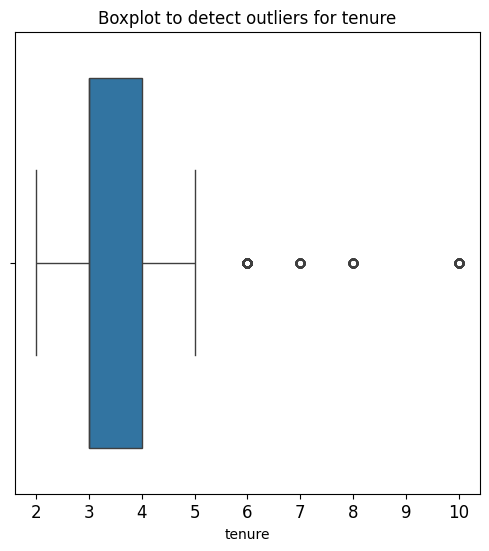

In [12]:
# create a boxplot to visualize the distribution of 'tenure' and detect any outliers
plt.figure(figsize=(6,6))
plt.title("Boxplot to detect outliers for tenure", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df1['tenure'])
plt.show()

In [13]:
# determine number of rows containing outliers

percentile_25 = df1['tenure'].quantile(0.25)
percentile_75 = df1['tenure'].quantile(0.75)
iqr = percentile_75 - percentile_25

upper_limit = percentile_75 + 1.5*iqr
lower_limit = percentile_25 - 1.5*iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

outliers = df1[(df1['tenure'] > upper_limit) | (df1['tenure'] < lower_limit)]
print("Number of rows in the data containing outliers in 'tenure':", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in 'tenure': 824


There are 824 rows containing outliers in the `tenure` variable. Since I will use RandomForestClassifier and XGBoost, I don't need to removed them because those models are robust to outliers.

### Step 2: Data Exploration (Continue EDA)

In [14]:
# get numbers of people who left vs stayed

print(df1['left'].value_counts())
print()

# get percentages of people who left vs stayed
print(df1['left'].value_counts(normalize=True))

left
0    10000
1     1991
Name: count, dtype: int64

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


#### Data visualizations

Creating plots to visualize relationships between variables in the data.

##### 1. Comparing employees who stayed versus those who left based on `number_project` and `average_monthly_hours`.

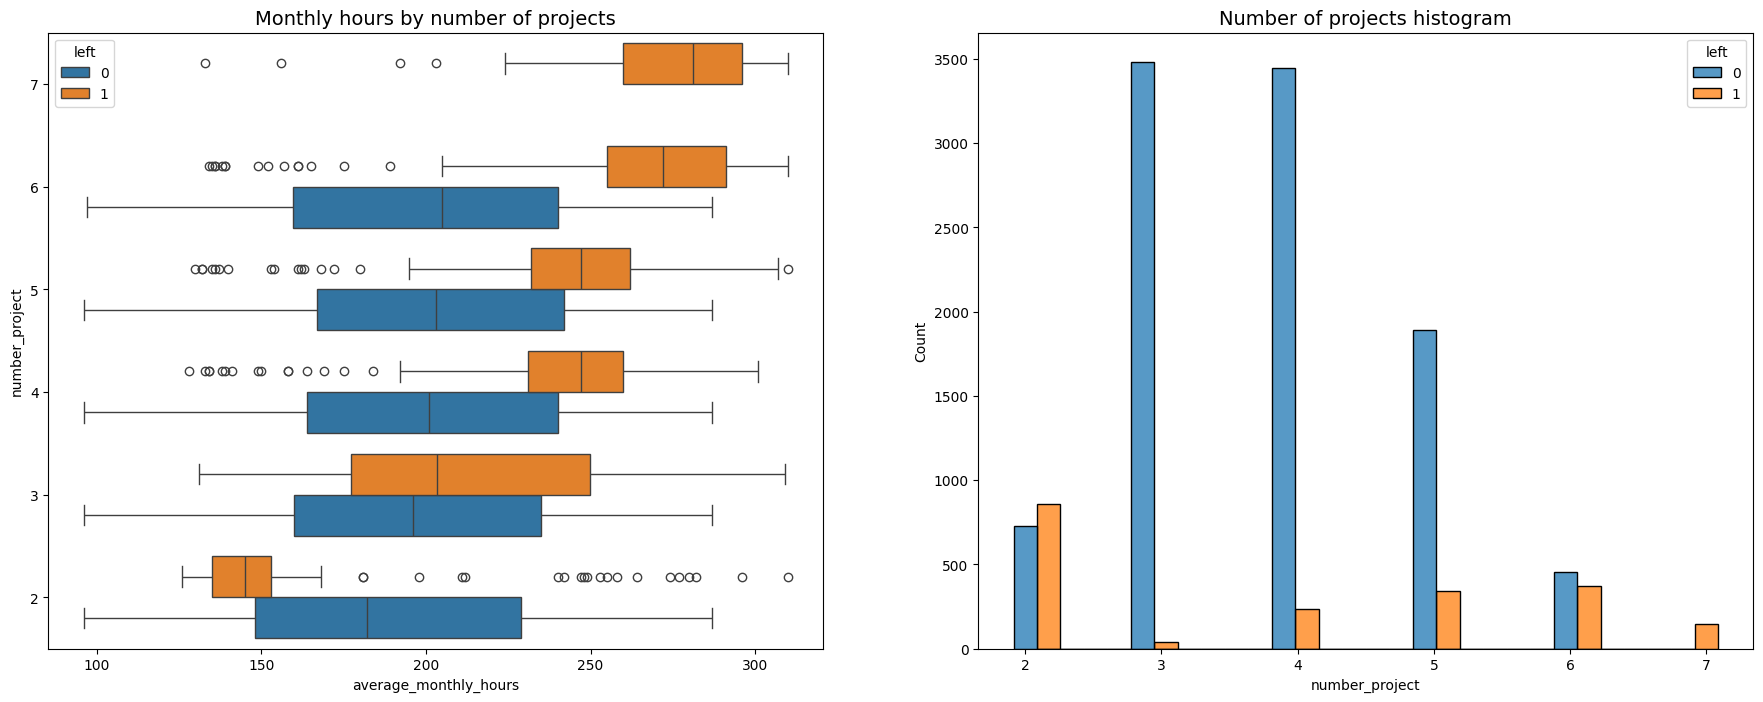

In [15]:
fig, ax = plt.subplots(1, 2, figsize= (22,8))

# create boxplots showing `average_monthly_hours` distributions for `number_project`, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient='h', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

# create histogram showing distribution of 'number_project', comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['number_project']
tenure_left = df1[df1['left']==1]['number_project']
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

plt.show()

Based on the graphs, it can be concluded that:

There are two kinds of employees who left, 1) the employees who has small number of project (2 projects) and low working hours (less than 150 hours per month) ; and 2) employees with high number of projects (6-7 projects with high working hours approximately above 250 hours per month). The first category is probably employees who have been noticed to leave the company, so they were assigned with less number of projects. The second category employee is most likely leave the company because they have worked so hard with high number of projects as well as high working hours.

If we assume there are 50 effective weeks and 2 weeks of vacation in a year, and a work week is 40 hours, then the average number of working hours per month of employees working Monday-Friday `= 50 weeks * 40 hours per week / 12 months = 166.67 hours per month.`
From the boxplot, we see that employees with 6-7 number of projects has working hours more than 250 hours per month. So, this is very reasonable if they leave the company because they have worked really hard, even above the average of working hours per month.

From the bar chart, it is seen that employees who did 7 projects are all leaving the company, we can see how many of them.

In [16]:
# get the value counts of stayed/left for employees with 7 projects
df1[df1['number_project']==7]['left'].value_counts()

left
1    145
Name: count, dtype: int64

##### 2. Examine the `average_monthly_hours` versus `satisfaction_level`.

Text(0.5, 1.0, 'Monthly hours by last evaluation score')

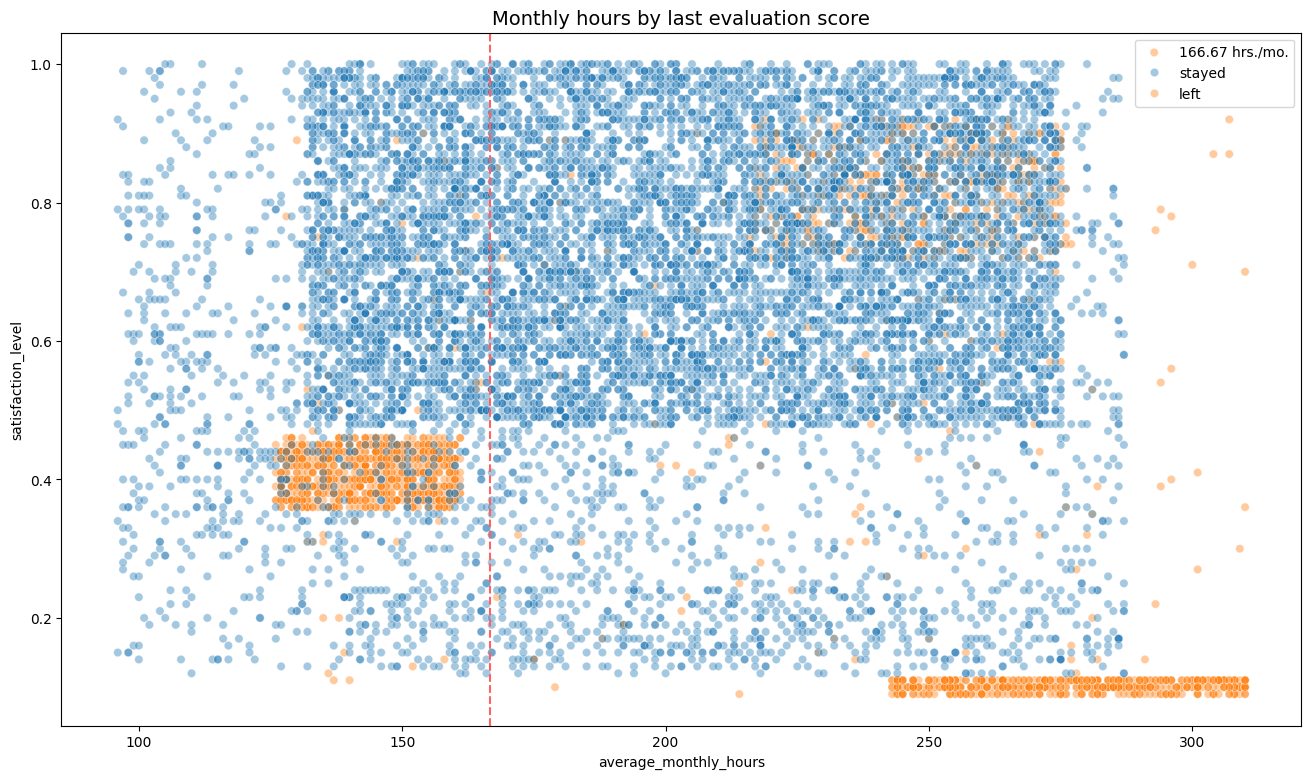

In [17]:
# create scatterplot of `average_monthly_hours` versus `satisfaction_level`, comparing employees who stayed versus those who left
plt.figure(figsize=(16,9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'stayed', 'left'])
plt.title('Monthly hours by last evaluation score', fontsize='14')

Based on the scatterplot above, there are 3 categories of employees who left based on their average monthly hours of working:

- employees who left with satisfaction level close to zero. These employees mostly work for ~240 until 315 hours per month. 315 hours per month is over 75 hours per week for the whole year. So this is absolutely reasonable why they left the company and the satisfaction level is nearly zero. They must be very exhausted.

- employees who left with satisfation level around 0.4. In this category, the employees have working hours ranging from ~130 - 160 hours per month. Actually the working hours is still good, but their satisfaction level is low, so it is unclear what caused them left the company. It is possible that they feel pressured to work more, considering many of their peers worked more.

- employees who left with satisfaction level ranging from 0.7 - 0.9. Their working hours ranging from 210 - 280 hours per month. This is quite busy work indeed.

##### 3. Explore `satisfaction_level` by `tenure`.

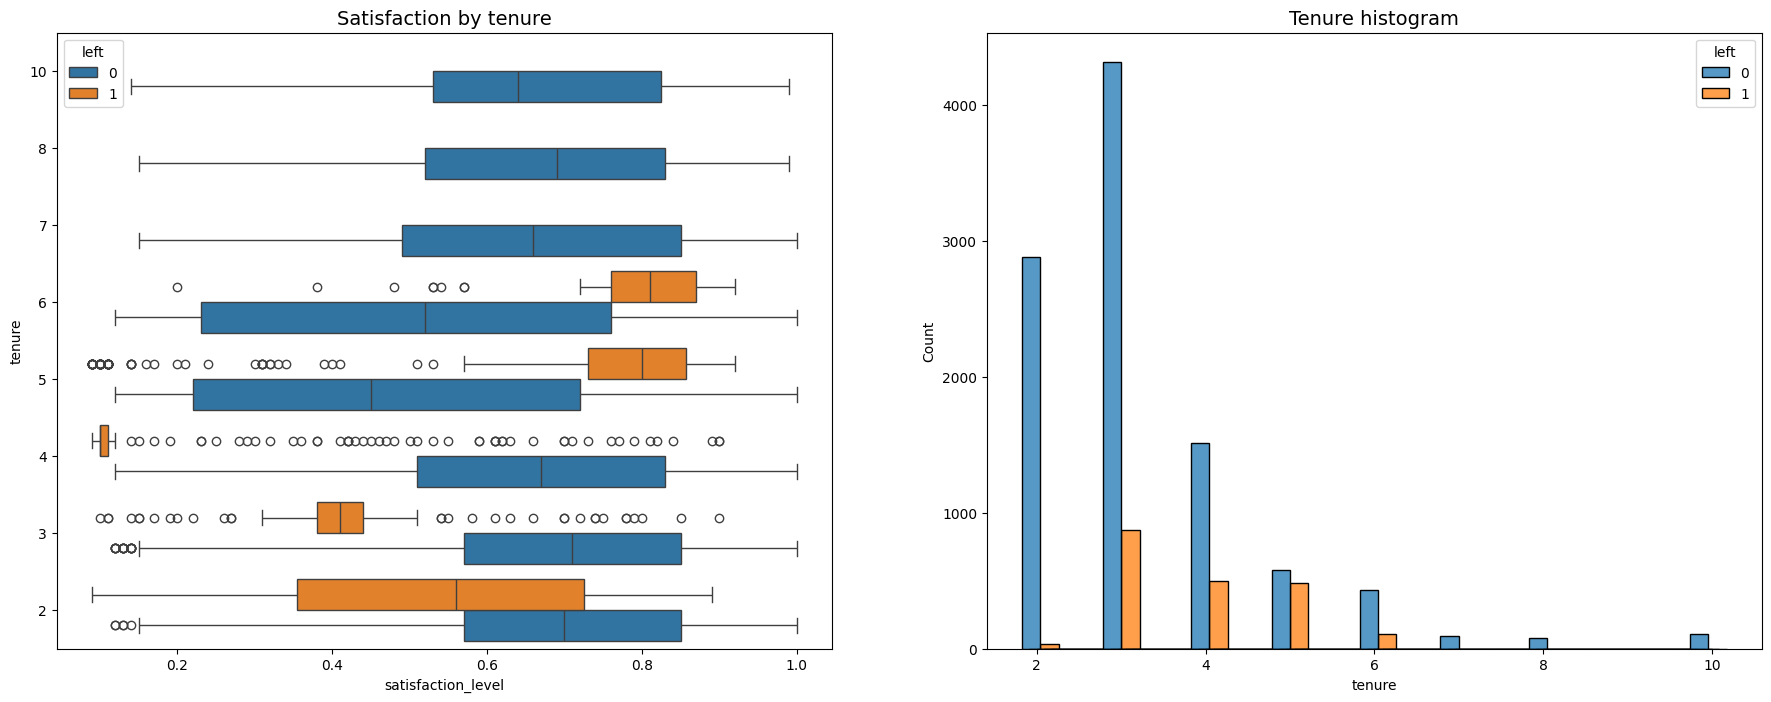

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(22,8))

# create boxplot showing distribution of `satisfaction_level` by `tenure`, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient='h', ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Satisfaction by tenure', fontsize='14')

# create histogram showing distribution of `tenure`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['tenure']
tenure_left = df1[df1['left']==1]['tenure']
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1])
ax[1].set_title('Tenure histogram', fontsize='14')
plt.show()

Based on the graphs, the data represents:

- employees who left based on tenure and satisfaction level fall into two categories, 1) dissatisfied employees with short tenure(2-4 years); 2) very satisfied employees with medium-length tenure.
- employees with 4 years tenure having very low satisfaction level should be investigated.
- employees having the longest tenure didn't leave, they also have high satisfaction level. This could be because these employees are high-paid employees.

Next, we can calculate the mean and median satisfaction scores of employees who left and those who did not.

In [19]:
# calculate mean and median satisfaction scores of employees who left and those who stayed
df1.groupby(['left'])['satisfaction_level'].agg([np.mean, np.median])

C:\Users\HP\AppData\Local\Temp\ipykernel_10520\3509979963.py:2: FutureWarning: The provided callable <function mean at 0x0000020427DE2340> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df1.groupby(['left'])['satisfaction_level'].agg([np.mean, np.median])
C:\Users\HP\AppData\Local\Temp\ipykernel_10520\3509979963.py:2: FutureWarning: The provided callable <function median at 0x0000020427F2B2E0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df1.groupby(['left'])['satisfaction_level'].agg([np.mean, np.median])


,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


It can be seen that employees who left having lower score of mean and median satisfaction level. On the other side, employees who stayed have lower mean than its median, meaning that the satisfaction among those who stayed might be skewed to the left.

##### 4. Examine `salary` levels for different `tenure`.

Text(0.5, 1.0, 'Salary histogram by tenure: long-tenured employees')

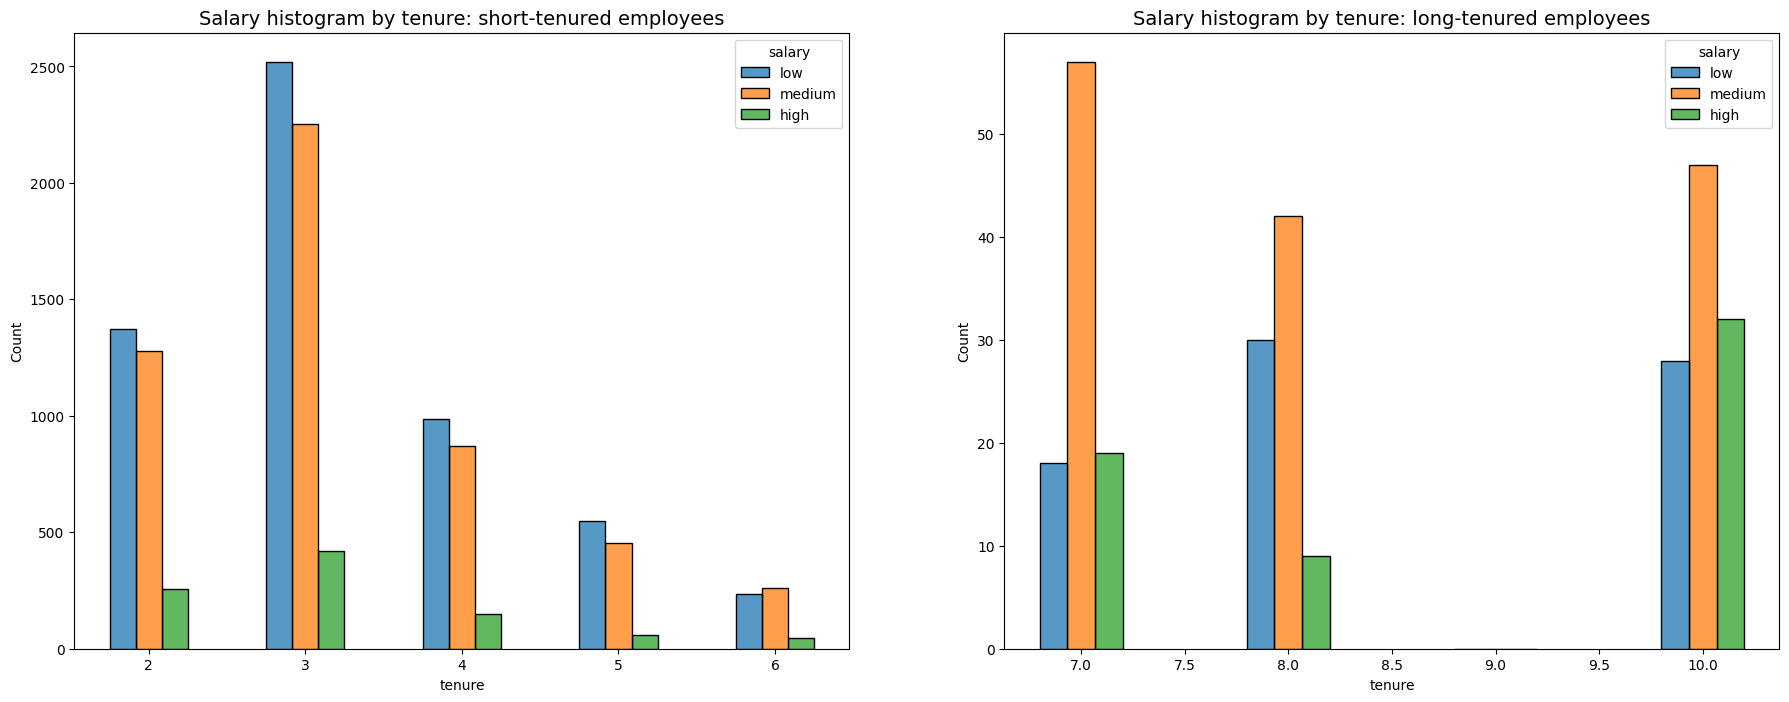

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(22,8))

# define short-tenured employees
tenure_short = df1[df1['tenure']<7]

# define long-tenured employees
tenure_long = df1[df1['tenure']>6]

# plot short-tenured histogram
sns.histplot(data=tenure_short, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.5, ax=ax[0])
ax[0].set_title('Salary histogram by tenure: short-tenured employees', fontsize='14')

#plot long-tenured histogram
sns.histplot(data=tenure_long, x='tenure', hue='salary', discrete=1, 
             hue_order=['low', 'medium', 'high'], multiple='dodge', shrink=.4, ax=ax[1])
ax[1].set_title('Salary histogram by tenure: long-tenured employees', fontsize='14')

Based on the plots, it is seen that short-tenured employees are mostly paid with low salary. However, becoming a long-tenured employee does not guarantee to have a higher salary. From the second graph, we see that long-tenured employees are mostly paid with medium salary, but the number of employees getting medium-high salary is very low.

5. Examine whether there's a correlation between working long hours and receiving high evaluation scores using `average_monthly_hours` and `last_evaluation`.

Text(0.5, 1.0, 'Monthly hours by evaluation score')

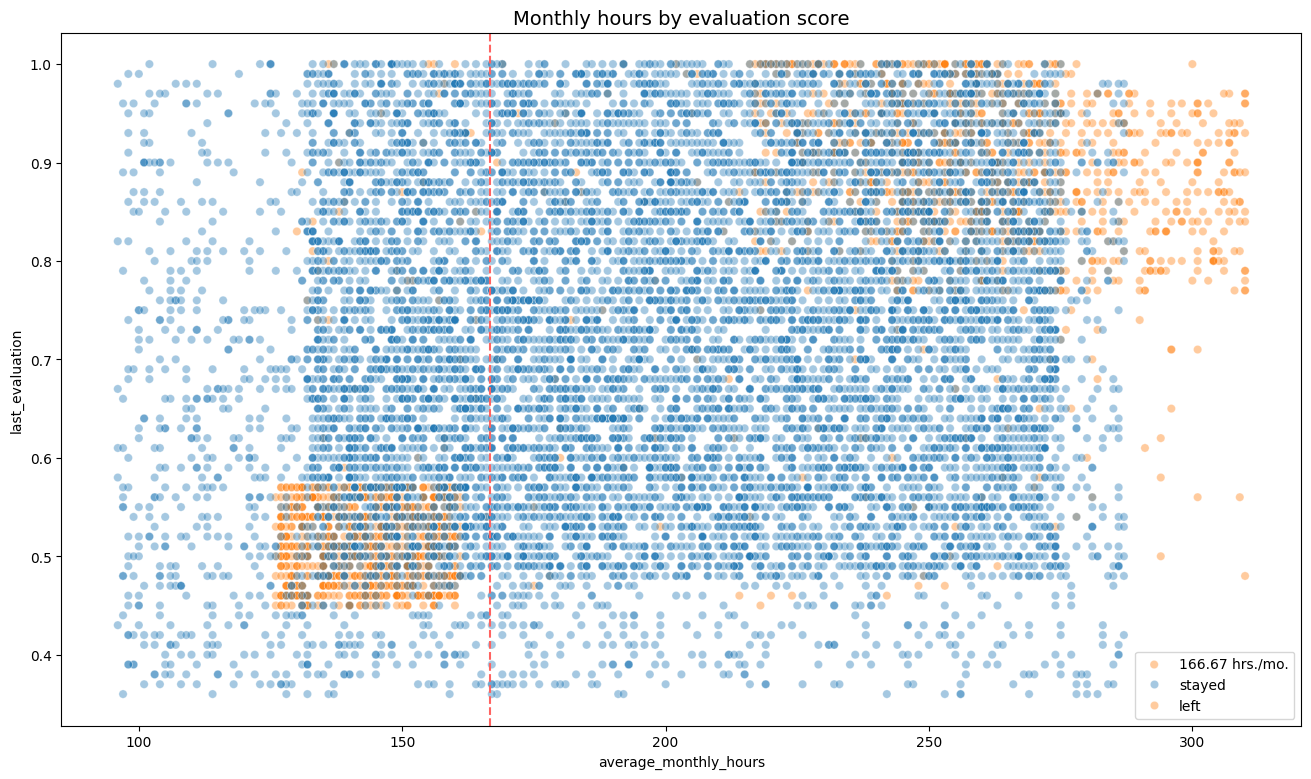

In [21]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'stayed', 'left'])
plt.title('Monthly hours by evaluation score', fontsize='14')

Based on the scattterplot, the following observations are:

- There are 2 types of employees who left, 1) employees with high performance; 2) employees who worked under monthly average working hours with low performance.

- There seems to be a correlation between working hours and evaluation score.

- There isn't high percentage of employees in the upper left quadrant of this plot (average monthly hours < 150), but long working hours does not guarantee a  good evaluation score.

- Most of the employees work well with above average monthly working hours (above 166.67 hours).

6. Examine whether employees who worked very long hours were promoted in the last five years.

Text(0.5, 1.0, 'Monthly hours by promotion last 5 years')

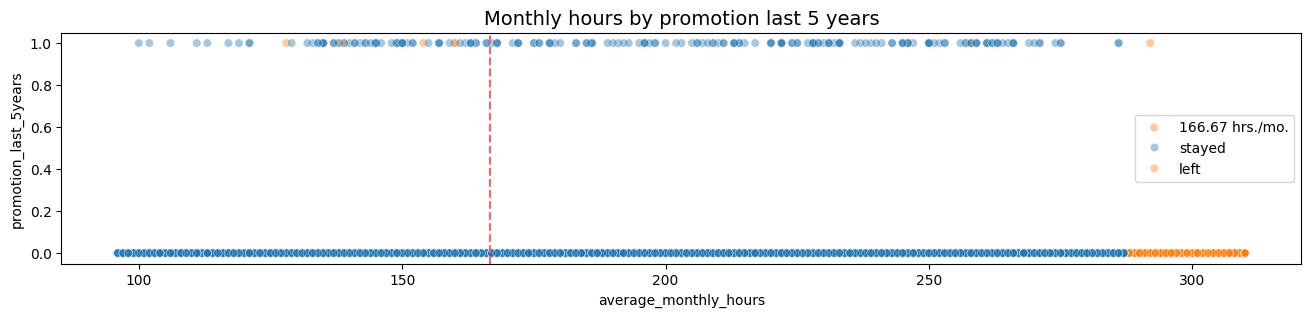

In [22]:
# create plot to examine relationship between `average_monthly_hours` and `promotion_last_5years`
plt.figure(figsize=(16,3))
sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'stayed', 'left'])
plt.title('Monthly hours by promotion last 5 years', fontsize='14')

The plot above shows that:

- very fews employees get promoted in the last 5 years
- very fews employees who worked the most hours get promoted
- all of the employees who left working the longest hours

Inspect how the employees who left are distributed accross departments.

In [23]:
# display counts for each department
df1['department'].value_counts()

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

Text(0.5, 1.0, 'Counts of stayed/left by department')

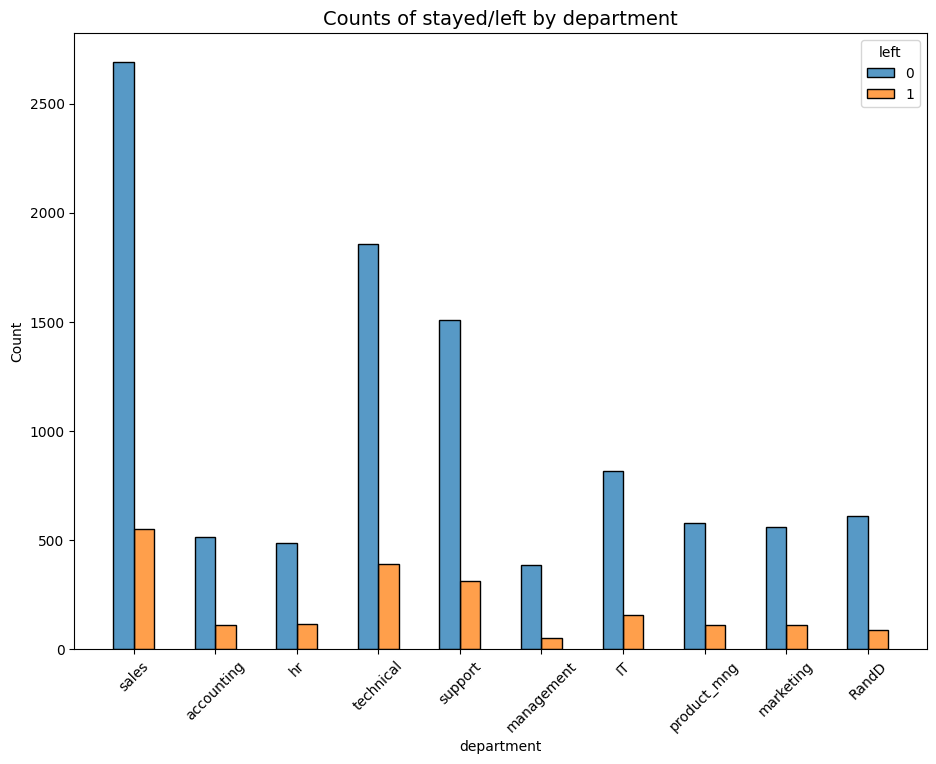

In [24]:
# create stacked histogram to compare department distribution of employees who left to that of employees who didn't
plt.figure(figsize=(11,8))
sns.histplot(data=df1, x='department', hue='left', discrete=1,
             hue_order=[0,1], multiple='dodge', shrink=.5)
plt.xticks(rotation=45)
plt.title('Counts of stayed/left by department', fontsize='14')

There doesn't seem to be any department that differs significantly in proportion of employees who left to those who stayed.

Check for strong correlations between variables in the data.

Text(0.5, 1.0, 'Correlation Heatmap')

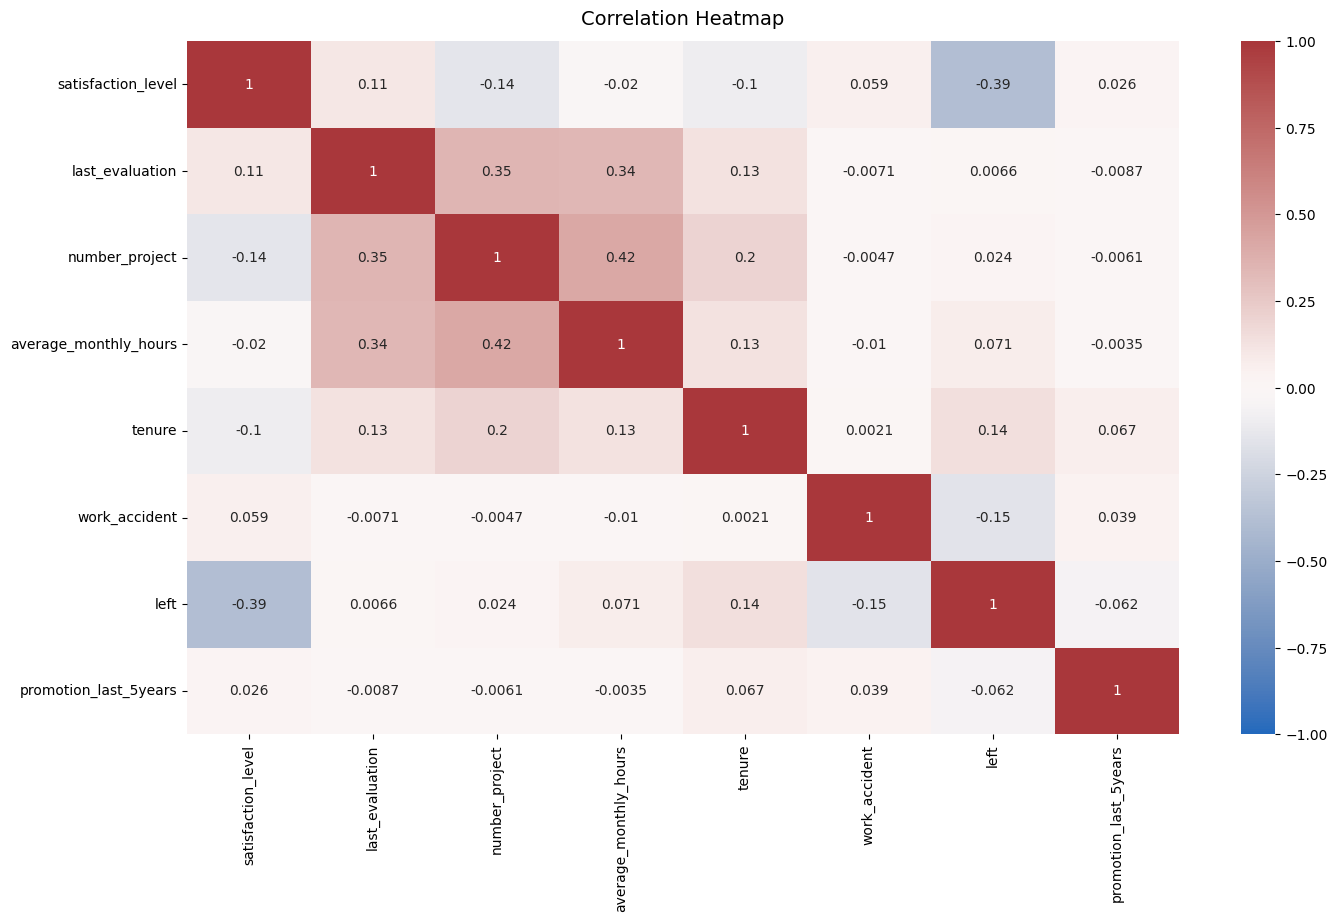

In [25]:
numeric_df = df0.select_dtypes(include=[float, int])

plt.figure(figsize=(16,9))
heatmap = sns.heatmap(numeric_df.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)

The correlation heatmap confirms that:

- `number_project`, `last_evaluation` and `average_monthly_hours`are positively correlated with each other
- `left` and `satisfaction_level` are negatively correlated with each other, meaning that the lower the satisfaction level, the higher the possibility of the employees to leave the company.

### Insights

Based on the exploratory data analysis, we found that:

- Employees left the company affected by some strong factors, including working hours (`average_monthly_hours`), number of projects (`number_project`), satisfaction level (`satisfaction_level`), evaluation (`last_evaluation`) and the chance getting promoted (`promotion_last_5years`).
- The higher working hours and the number of projects (especially employees who worked with 7 projects and more than 210 hours per month), the higher chance of the employees to leave.
- Moreover, with the chance getting promoted is very low, employees who worked with high working hours are leaving the company.
- Employees who have worked for above 7 years are not leaving, this maybe because they are high-paid employees.

### Step 3: Feature Engineering

The objective of this project is to predict whether an employee will leave the company, so this is a classification task. In that case, I will try to use RandomForest and XGBoost model. Before execute it, we have to make sure that all of variables are numeric and categorical variable should be encoded to numeric.This dataset has `department` and `salary` column which are categorical, so we have to encode it first.

In [26]:
# copy the dataframe
df_enc = df1.copy()

# encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

# dummy encode the `department` column
df_enc = pd.get_dummies(df_enc, drop_first=False)

# display the new dataframe
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [27]:
# convert data type to integer
df_enc = df_enc.astype(int)

df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0,0,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0,0,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0,0,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


### Step 4: Model Building

In [28]:
# examine the class balance of the target variable
df_enc['left'].value_counts(normalize=True)

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64

There is an approximately 83% - 17% split, this is an imbalanced dataset, but not too imbalanced. We can proceed without modifying the class balance. 
In this dataset, I will divide the data into 60% of training data, 20% validation data, and 20% test data. So, the mechanism is training the model using training data, then fit the model into validation data. The best AUC score resulting of fitted model using validation data is the champion model. Next, the champion model is applied to the test data.

In [29]:
# isolate X variables
X = df_enc.drop('left', axis=1)

#isolate y variable
y = df_enc['left']

# split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

# split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr, test_size=0.25, random_state=0)

Verify the number of samples in the partitioned data.

In [30]:
for x in [X_train, X_val, X_test]:
    print(len(x))

7194
2398
2399


#### **Random Forest**

In [31]:
# instantiate model
rf = RandomForestClassifier(random_state=0)

# assign a dictionary of hyperparameter to search over
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
            }

# assign a dictionary of scoring metrics to capture
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'}

# instantiate GridSearch
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fit the model to the training data.

In [32]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 9.81 s
Wall time: 19.2 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

Examine the best average score across all the validation folds.

In [33]:
# examine best score
rf_cv.best_score_

np.float64(0.9639921368977766)

Examine the best combination of hyperparameters.

In [34]:
# examine the best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [35]:
def make_results(model_name:str, model_object, metric:str):
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }
    cv_results = pd.DataFrame(model_object.cv_results_)
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(),:]

    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                         'precision': [precision],
                         'recall': [recall],
                         'F1': [f1],
                         'accuracy': [accuracy],
                         'auc': [auc]
                         })
    return table

In [36]:
# get all CV scores
rf_results = make_results('Random Forest CV', rf_cv, 'auc')
rf_results

,model,precision,recall,F1,accuracy,auc
0,Random Forest CV,0.881964,0.855239,0.867684,0.95677,0.963992


#### **XGBoost**

In [37]:
# instantiate the XGBoost classifier 
xgb= XGBClassifier(objective='binary:logistic', random_state=0)

# create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
            }

# define a dictionary of scoring metrics to capture
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'}

# instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fit the model to `X_train` and `y_train` data.

In [38]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 47.1 s
Wall time: 32.5 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [39]:
# examine the best score
xgb_cv.best_score_

np.float64(0.970214426313389)

In [40]:
# examine the best parameters
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 12,
 'min_child_weight': 3,
 'n_estimators': 300}

In [41]:
# call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGBoost CV', xgb_cv, 'auc')
results = pd.concat([rf_results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy,auc
0,Random Forest CV,0.881964,0.855239,0.867684,0.956770,0.963992
0,XGBoost CV,0.886561,0.866964,0.876322,0.959411,0.970214


Overall, XGBoost model slightly outperforms RandomForest model across all key metrics. Especially on AUC value, which indicates XGBoost CV has better ability to distinguish employees who left and who did not leave the company for this dataset.

### Step 5: Model Selection

#### **Random Forest**

In [42]:
# use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

Use the `get_test_scores()` function to generate a table of scores from the predictions on the validation data.

In [43]:
def get_test_scores(model_name:str, preds, y_test_data):
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    auc = roc_auc_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                         'precision': [precision],
                         'recall': [recall],
                         'F1': [f1],
                         'accuracy': [accuracy],
                         'auc': [auc]
                         })
    return table

In [44]:
# get validation scores for RF model
rf_val_scores = get_test_scores('Random Forest CV Val', rf_val_preds, y_val)

# append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy,auc
0,Random Forest CV,0.881964,0.855239,0.867684,0.956770,0.963992
0,XGBoost CV,0.886561,0.866964,0.876322,0.959411,0.970214
0,Random Forest CV Val,0.894872,0.876884,0.885787,0.962469,0.928192


#### **XGBoost**

In [45]:
# use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGBoost CV Val', xgb_val_preds, y_val)

# append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy,auc
0,Random Forest CV,0.881964,0.855239,0.867684,0.956770,0.963992
0,XGBoost CV,0.886561,0.866964,0.876322,0.959411,0.970214
0,Random Forest CV Val,0.894872,0.876884,0.885787,0.962469,0.928192
0,XGBoost CV Val,0.897243,0.899497,0.898369,0.966222,0.939499


Overall, XGBoost model's validation scores are higher than all models, though very slightly. However, AUC scores are decreasing for both models, but XGBoost still has higher AUC score compare to RandomForest model, showing that XGBoost is an accurate and robust model. So, the champion model is XGBoost.

### Step 6: Use champion model to predict on test data

This is to give a final indication of how you should expect the model to perform on new future data, should you decide to use the model.

In [46]:
# use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGBoost Test', xgb_test_preds, y_test)

# append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy,auc
0,Random Forest CV,0.881964,0.855239,0.867684,0.956770,0.963992
0,XGBoost CV,0.886561,0.866964,0.876322,0.959411,0.970214
0,Random Forest CV Val,0.894872,0.876884,0.885787,0.962469,0.928192
0,XGBoost CV Val,0.897243,0.899497,0.898369,0.966222,0.939499
0,XGBoost Test,0.877193,0.879397,0.878294,0.959566,0.927455


Recall, F1, and accuracy values on the test data are slightly higher than the training model, but the AUC and precision scores are declined, particularly the AUC score. Hence, making the precision score drops slightly. Nonetheless, this is still within the acceptable range for performance discrepancy between validation and test scores.

### Step 7: Confusion Matrix

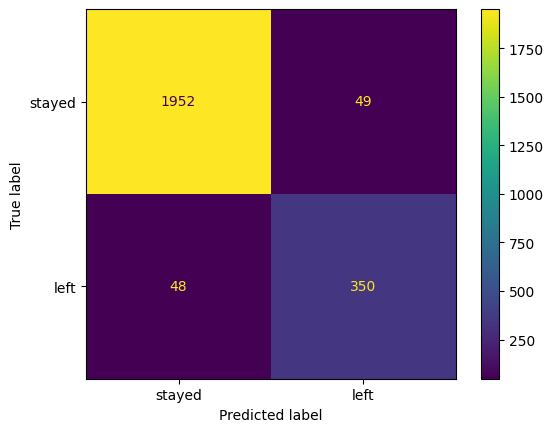

In [47]:
# generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['stayed', 'left'])
disp.plot()

The models predicts almost the same value of false positives and false negatives, with very low of predicting false values, meaning that this model effective in identifying employees who will stay or leave the company. 

### Step 8: Feature importance

Use feature importance to inspect the most important features of the final model.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

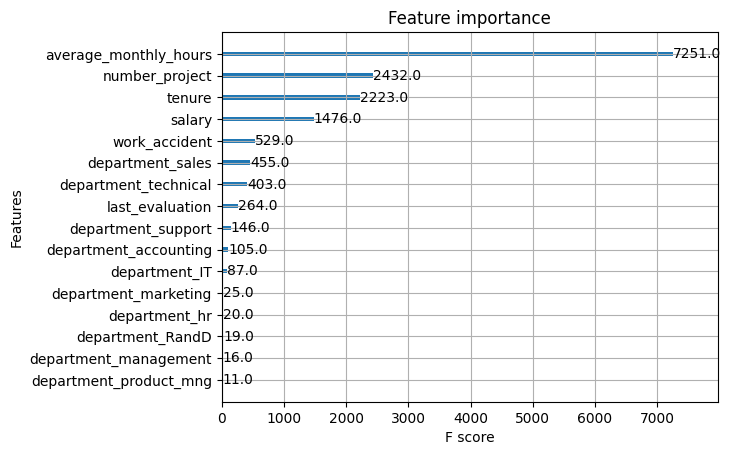

In [48]:
plot_importance(xgb_cv.best_estimator_)

The plot above shows that in XGBoost model, `average_monthly_hours`, `number_project`, `tenure` and `salary` have the highest importance, in that order. These variables are most helpful in predicting whether an employee will leave the company.

### Conclusion and Recommendation

The models and feature importances extracted from the models confirm that employees at the company are overworked.

To retain employees, the following recommendation should be considered:

- Limit number of projects that employees can work on.
- Consider promoting employees who have worked for at least 4 years.
- Provide bonus/reward for employees who worked more than 200+ hours/month.
- Consider increasing salary for employees who have long tenure and work for more than 200+ hours/month.